In [47]:
import pandas as pd
import tqdm
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import transformers
import torch
from sentence_transformers import SentenceTransformer

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN

Загрузим данные с помощью `pandas`

In [2]:
pd_data = pd.read_csv('./Restaurant_Reviews.tsv', sep='\t')
pd_data.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


В качестве эмбеддингов для текста будем использовать два энкодера:
* `roberta`, обученная для анализа тональности текста 
* `minilm` - энкодер после дистиляции

In [12]:
class ModelEncoder:
    def __init__(self, model_name) -> None:
        self.model_name = model_name
    
    def __preprocess_text(self, text):
        return text
    
    def __make_nested(self, text):
        if isinstance(text, str):
            text = [text,]
        return text

    def tokenize(self, text):
        new_text = []
        text = self.__make_nested(text)
        for t in text:
            new_text.append(self.__preprocess_text(t))
        encoded_input = self.tokenizer(
            new_text,
            return_tensors='pt',
            truncation=True,
            padding='longest',
            max_length=512
        )
        return encoded_input

    def vectorize(self, text, return_numpy=False):
        raise NotImplementedError('Not implemented')


class RobertaSentimentEncoder(ModelEncoder):
    def __init__(self, model_name) -> None:
        super().__init__(model_name)
        model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name)
        model.eval()
        self.model = model.roberta
        self.tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
    
    def __preprocess_text(self, text):
        new_text = []
        for t in text.split(" "):
            t = '@user' if t.startswith('@') and len(t) > 1 else t
            t = 'http' if t.startswith('http') else t
            new_text.append(t)
        return " ".join(new_text)
    
    @torch.no_grad()
    def vectorize(self, text, return_numpy=False):
        encoded_input = self.tokenize(text)
        output = self.model(**encoded_input)
        output = output.last_hidden_state[:, 0, :]
        if return_numpy:
            output = output.numpy()
        return output


class MiniLMEncoder(ModelEncoder):
    def __init__(self, model_name) -> None:
        super().__init__(model_name)
        self.model = SentenceTransformer(model_name)
    
    def __make_nested(self, text):
        if isinstance(text, str):
            text = [text,]
        return text

    @torch.no_grad()
    def vectorize(self, text, return_numpy=False):
        text = self.__make_nested(text)
        encoded = self.model.encode(text, convert_to_numpy=return_numpy)
        if not return_numpy:
            encoded = [e.unsqueeze(0) for e in encoded]
            encoded = torch.cat(encoded, dim=0)
        return encoded


encoders = {
    'roberta': RobertaSentimentEncoder('cardiffnlp/twitter-roberta-base-sentiment'),
    'minilm': MiniLMEncoder('all-MiniLM-L6-v2')
}
        

Прогоним данные через оба энкодера.

In [ ]:
batch_size = 50

def batched_encode(data, encoder, batch_size):
    data_vectorized = []
    target = []

    for start_ind in tqdm.tqdm(range(0, data.shape[0], batch_size)):
        data_slice = data.iloc[start_ind:start_ind + batch_size]
        target.extend(data_slice['Liked'].tolist())
        data_vectorized.append(encoder.vectorize(data_slice['Review'].tolist()))
    data_vectorized = torch.cat(data_vectorized, dim=0).numpy()
    target = np.array(target)
    return data_vectorized, target

data = {}
for key in encoders:
    print(f'Encoder: {key}')
    data_vectorized, target = batched_encode(pd_data, encoders[key], batch_size)
    data[key] = {
        'X': data_vectorized,
        'y': target
    }

Снизим размерность полученных эмбеддингов до 2х компонент.

In [14]:
for key in data:
    data[key]['X_reduced'] = PCA(n_components=2).fit_transform(data[key]['X'])

In [15]:
sns.set(rc={'figure.figsize':(9,6)}, font_scale=1)

def plot_pca(data_vectorized, target=None, title='Распределение данных по двум главным компонентам'):
    figure = plt.figure()
    ax = figure.add_subplot(111)
    if target is None:
        ax.scatter(x=data_vectorized[:, 0], y=data_vectorized[:, 1], color='blue')
    else:
        unique_labels = np.unique(target).tolist()
        for l in unique_labels:
            r, g, b = np.round(np.random.rand(), 1), np.round(np.random.rand(), 1), np.round(np.random.rand(), 1)
            class_mask = target == l
            ax.scatter(x=data_vectorized[class_mask][:, 0], y=data_vectorized[class_mask][:, 1], color=[r, g, b])
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')

    ax.set_title(title)
    # plt.show()
    return ax

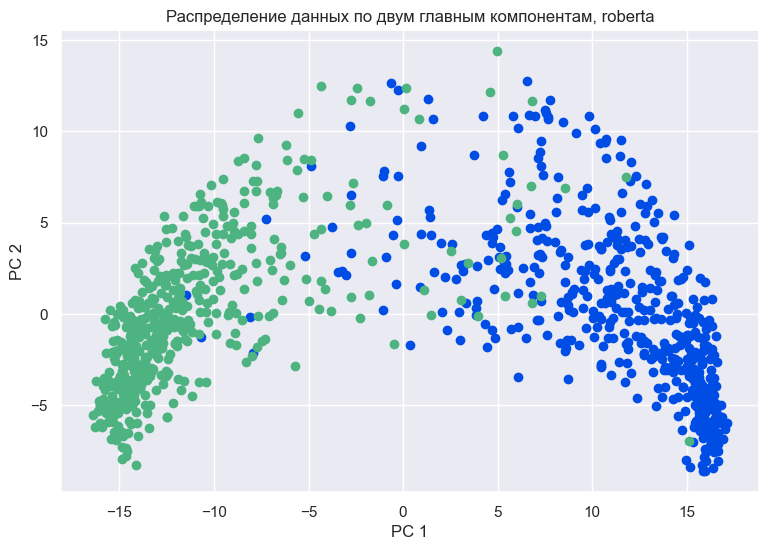

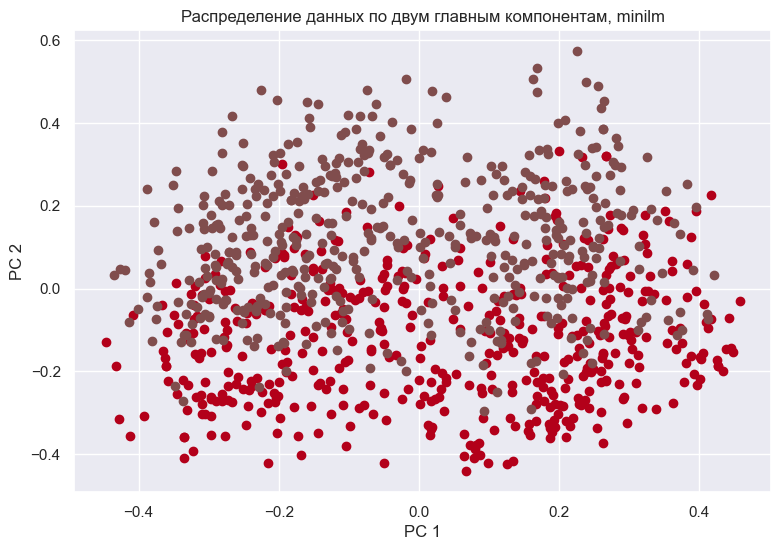

In [20]:
ax1 = plot_pca(data['roberta']['X_reduced'], target, 'Распределение данных по двум главным компонентам, roberta')
ax2 = plot_pca(data['minilm']['X_reduced'], target, 'Распределение данных по двум главным компонентам, minilm')

Как можно заметить, кластеризировать лучше эмбеддинги роберты, т.к разбиение на кластеры просматриваются более явно.

В качестве алгоритмов кластеризации будем использовать `KMeans` и `DBSCAN`

## KMeans

<Axes: title={'center': 'Распределение данных по двум главным компонентам, roberta + KMeans'}, xlabel='PC 1', ylabel='PC 2'>

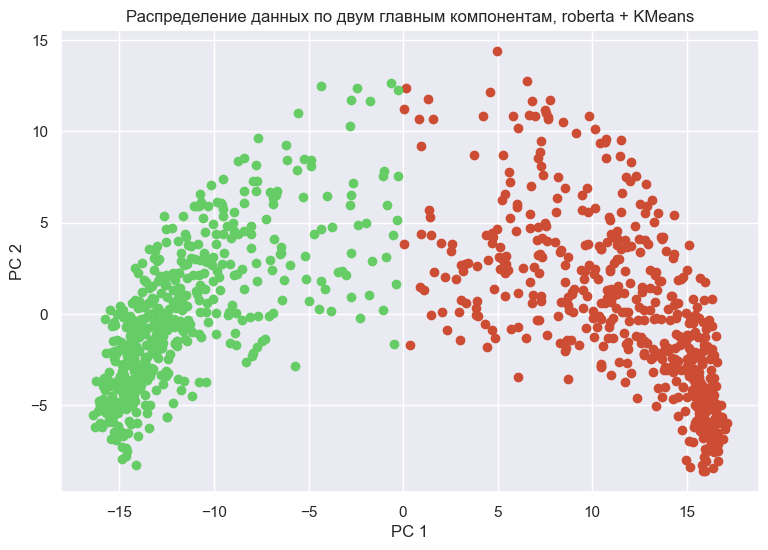

In [27]:
k_means = KMeans(
    n_clusters=2,
    init='k-means++',
    n_init=15,
    max_iter=500,
    random_state=17
)

clusters = k_means.fit_predict(data['roberta']['X_reduced']) # использоваем сниженную размерность
plot_pca(data['roberta']['X_reduced'], clusters, 'Распределение данных по двум главным компонентам, roberta + KMeans')

In [31]:
inertia = []
for i in range(2, 10):
    k_means = KMeans(
        n_clusters=i,
        init='k-means++',
        n_init=15,
        max_iter=500,
        random_state=17
    )
    k_means.fit(data['roberta']['X_reduced'])
    inertia.append(k_means.inertia_)

In [32]:
inertia

[35746.4375,
 21421.5,
 14520.65625,
 11559.30078125,
 9682.09375,
 7822.96435546875,
 6815.345703125,
 5989.40771484375]

In [35]:
from sklearn.metrics import silhouette_score

silhouette = {}
for i in range(2,10):
    k_means = KMeans(n_clusters=i,
        init='k-means++',
        n_init=15,
        max_iter=500,
        random_state=17
    )
    k_means.fit(data['roberta']['X_reduced'])
    
    silhouette[i] = silhouette_score(data['roberta']['X_reduced'], k_means.labels_, metric='euclidean')

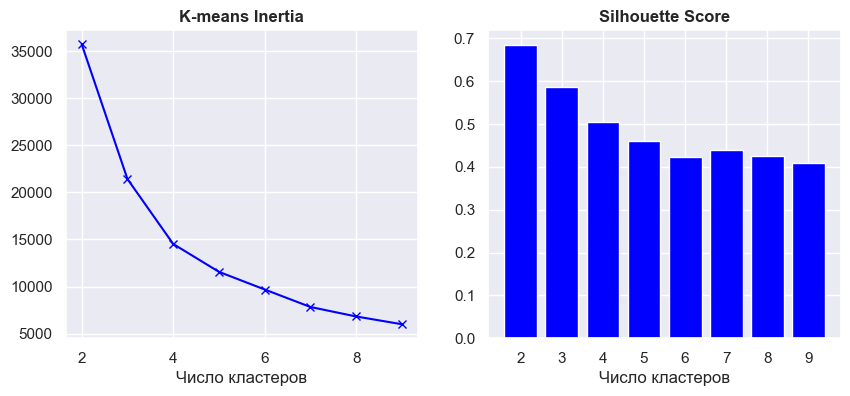

In [37]:
sns.set(font_scale=1, rc={'figure.figsize':(10,4)})

plt.subplot(1, 2, 1)

plt.plot(range(2,len(inertia)+2), inertia, marker='x',color='blue') 

plt.xlabel('Число кластеров')
plt.title('K-means Inertia',fontweight='bold')
plt.grid(True)

plt.subplot(1, 2, 2)

plt.bar(range(len(silhouette)), list(silhouette.values()), align='center',color= 'blue')
plt.xticks(range(len(silhouette)), list(silhouette.keys()))
plt.grid(True)
plt.title('Silhouette Score',fontweight='bold')
plt.xlabel('Число кластеров')


plt.show()

## DBSCAN

<Axes: title={'center': 'Распределение данных по двум главным компонентам, roberta + DBSCAN'}, xlabel='PC 1', ylabel='PC 2'>

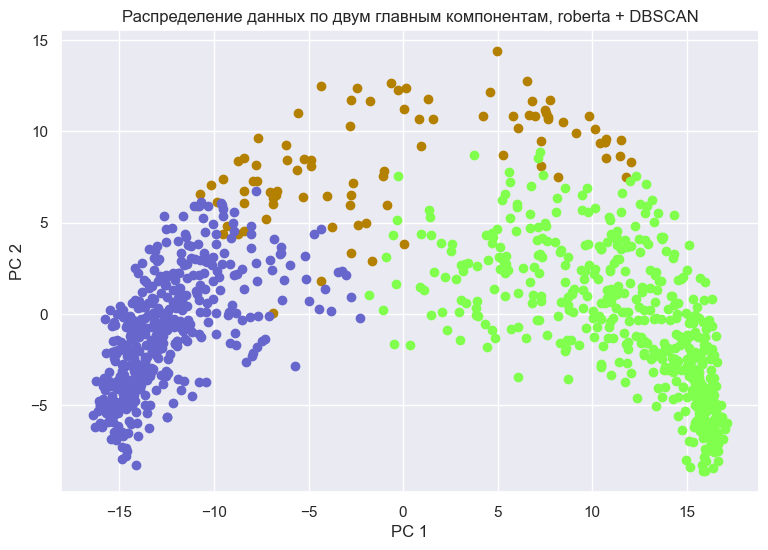

In [82]:
sns.set(rc={'figure.figsize':(9,6)}, font_scale=1)

dbscan = DBSCAN(eps=9.7, min_samples=140, algorithm='ball_tree', metric='euclidean', leaf_size=90, p=2)
dbscan_clusters = dbscan.fit_predict(data['roberta']['X'])
plot_pca(data['roberta']['X_reduced'], dbscan_clusters, 'Распределение данных по двум главным компонентам, roberta + DBSCAN')

In [77]:
from sklearn.metrics import silhouette_score

silhouette_dbscan = {}
for i in range(50,150, 10):
    dbscan = DBSCAN(eps=9.7, min_samples=i, algorithm='ball_tree', metric='euclidean', leaf_size=90, p=2)
    dbscan.fit(data['roberta']['X'])
    
    silhouette_dbscan[i] = silhouette_score(data['roberta']['X_reduced'], dbscan.labels_, metric='euclidean')

In [78]:
silhouette_dbscan

{50: 0.05185592,
 60: 0.049335416,
 70: 0.04841415,
 80: 0.047520384,
 90: 0.5436847,
 100: 0.54496706,
 110: 0.5491799,
 120: 0.54838,
 130: 0.5482341,
 140: 0.54945314}

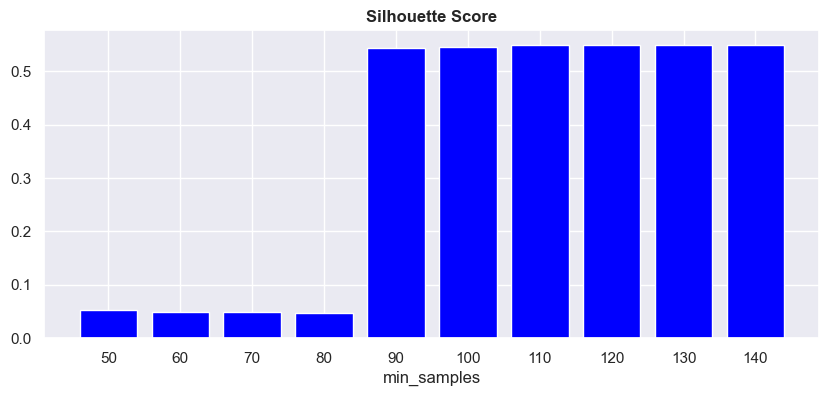

In [81]:
sns.set(font_scale=1, rc={'figure.figsize':(10,4)})

plt.bar(range(len(silhouette_dbscan)), list(silhouette_dbscan.values()), align='center',color= 'blue')
plt.xticks(range(len(silhouette_dbscan)), list(silhouette_dbscan.keys()))
plt.grid(True)
plt.title('Silhouette Score',fontweight='bold')
plt.xlabel('min_samples')

plt.show()